In [55]:
import numpy as np 
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from sklearn.random_projection import johnson_lindenstrauss_min_dim, SparseRandomProjection, GaussianRandomProjection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import time

In [56]:
X = np.load("train_x.npy").squeeze()
X.shape

(11938, 64, 64)

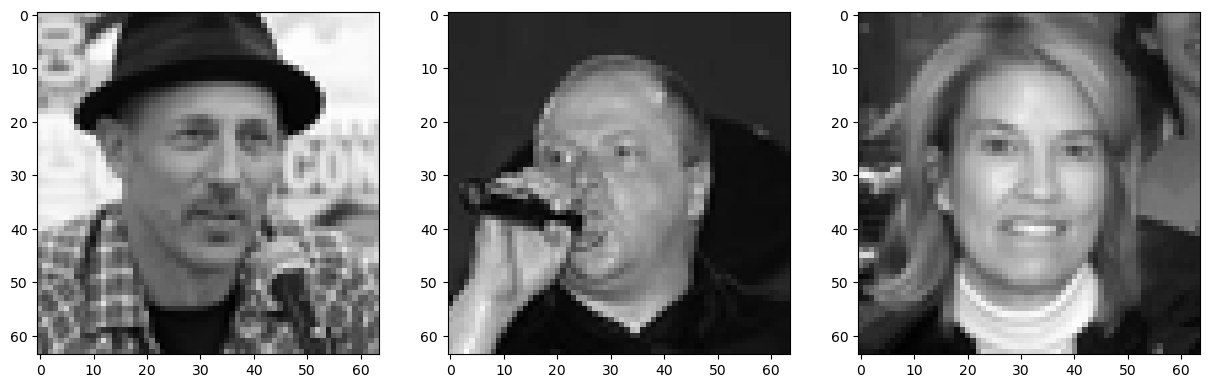

In [57]:
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.imshow(X[0].T,cmap='gray')
fig.add_subplot(132)
plt.imshow(X[1].T,cmap='gray')
fig.add_subplot(133)
plt.imshow(X[-1].T,cmap='gray')
plt.show()

In [58]:
X = X.reshape(11938, 64*64)
X.shape

(11938, 4096)

In [59]:
y = np.load("train_y.npy")[:,0]
y

array([0., 0., 0., ..., 1., 1., 1.])

In [60]:
X = MinMaxScaler().fit_transform(X)

In [61]:
alpha = 0.2
epsilon = 0.6

n, d = X.shape
print("số điểm dữ liệu: ",n)
print("số chiều dữ liệu: ",d)
print("k=",np.ceil((4 + 2*alpha) * np.log(n) / (epsilon**2/2 - epsilon**3/3)))

print(1 - n**(-alpha))

số điểm dữ liệu:  11938
số chiều dữ liệu:  4096
k= 383.0
0.847027387020438


## LogisticRegression

In [62]:
start_time = time.time()
clf = LogisticRegression(random_state=0)
clf.fit(X, y)
print("Thoi gian chay: ", time.time()- start_time)

y_pred=clf.predict(X)
print("accuracy", accuracy_score(y, y_pred))

Thoi gian chay:  3.9432804584503174
accuracy 0.8311274920422181


c:\Users\dat\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
def jl_pca(X, epsilon, alpha, n_components):
    # Tính toán số chiều mới theo JL lemma
    n, d = X.shape # số chiều ban đầu
    k = int(np.ceil((4 + 2*alpha) * np.log(n) / (epsilon**2/2 - epsilon**3/3)))
    print(k)
    # Tạo ma trận ngẫu nhiên cho JL lemma
    R = np.random.normal(size=(d, k))/np.sqrt(k)
    print("Voi xac suat khong nho hon:", 1 - n**(-alpha))
    # Áp dụng JL lemma lên dữ liệu X
    X_jl = X@R
    
    # Thực hiện PCA trên dữ liệu mới giảm chiều
    pca = PCA(n_components=n_components)
    pca.fit(X_jl)
    print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_)}")

    X_pca = pca.transform(X_jl)
    
    return X_pca
  
# Áp dụng JL lemma và PCA để giảm chiều dữ liệu

start_time = time.time()
clf = LogisticRegression(random_state=0)
X_pca = jl_pca(X, epsilon=0.6, alpha=0.2, n_components=20)
clf.fit(X_pca,y )
y_pred=clf.predict(X_pca)
print("Thoi gian chay: ", time.time()- start_time)

print("accuracy", accuracy_score(y, y_pred))

383
Voi xac suat khong nho hon: 0.847027387020438
Explained variance ratio: 0.8139804179285258
Thoi gian chay:  0.3222966194152832
accuracy 0.799547662925113


In [69]:
from sklearn.pipeline import make_pipeline
model = make_pipeline(GaussianRandomProjection(eps=0.6, random_state=0),PCA(n_components=20),LogisticRegression(random_state=0))
start_time = time.time()
model.fit(X, y)
y_pred_jl = model.predict(X)
print("Thoi gian chay: ", time.time()-start_time)

print("accuracy", accuracy_score(y, y_pred_jl))

Thoi gian chay:  0.5633106231689453
accuracy 0.8013067515496733


In [74]:
from sklearn.pipeline import make_pipeline
model = make_pipeline(SparseRandomProjection(eps=0.6, random_state=0),PCA(n_components=20),LogisticRegression(random_state=0))
start_time = time.time()
model.fit(X, y)
y_pred_jl = model.predict(X)
print("Thoi gian chay: ", time.time()-start_time)

print("accuracy", accuracy_score(y, y_pred_jl))

Thoi gian chay:  2.0912234783172607
accuracy 0.8014742837996315


## KNeighborsClassifier

In [70]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
nbrs = KNeighborsClassifier(n_neighbors=5).fit(X, y)
nbrs.fit(X, y)
y_pred=nbrs.predict(X)
print("Thoi gian chay: ", time.time()- start_time)

print("accuracy", accuracy_score(y, y_pred))

Thoi gian chay:  7.512824535369873
accuracy 0.8418495560395376


In [71]:
start_time = time.time()
clf = KNeighborsClassifier(n_neighbors=5)
X_pca = jl_pca(X, epsilon=0.6, alpha=0.2, n_components=20)
clf.fit(X_pca, y)
y_pred=clf.predict(X_pca)
print("Thoi gian chay: ", time.time()- start_time)

print("accuracy", accuracy_score(y, y_pred))

383
Voi xac suat khong nho hon: 0.847027387020438
Explained variance ratio: 0.8203873640955728
Thoi gian chay:  0.5184979438781738
accuracy 0.8399229351650193


In [72]:
from sklearn.pipeline import make_pipeline
model = make_pipeline(GaussianRandomProjection(eps=0.6, random_state=0),PCA(n_components=20),KNeighborsClassifier(n_neighbors=5))
start_time = time.time()
model.fit(X, y)
y_pred_jl = model.predict(X)
print("Thoi gian chay: ", time.time()-start_time)

print("accuracy", accuracy_score(y, y_pred_jl))

Thoi gian chay:  0.8688859939575195
accuracy 0.8348132015412967


In [75]:
from sklearn.pipeline import make_pipeline
model = make_pipeline(SparseRandomProjection(eps=0.6, random_state=0),PCA(n_components=20),KNeighborsClassifier(n_neighbors=5))
start_time = time.time()
model.fit(X, y)
y_pred_jl = model.predict(X)
print("Thoi gian chay: ", time.time()-start_time)

print("accuracy", accuracy_score(y, y_pred_jl))

Thoi gian chay:  2.051438093185425
accuracy 0.8377450159155637
